# DATA-614 Final Project: Classifying Rock / Paper / Scissors

| University | Class | Student |
| ---------- | ----- | ---------- |
| Franklin University | 23/SU-DATA-612-Q1WW Online | [Matt Eland](https://MattEland.dev) (ID: 0771584) |

Code developed using VS Code and Jupyter Notebooks running on Anaconda and Python 3.9.12

---

## Project Overview

### Overall Approach

### Data Sources

#### Rock / Paper / Scissors Images Dataset

#### Rock / Paper / Scissors Game Moves Dataset

### Technologies Used

- **Python**
- **Pandas**
- **Plotly**
- **OpenCV**
- **SciKit Learn**

In [1]:
# Anaconda doesn't come with OpenCV by default, so install the headless version
!pip install opencv-python-headless

In [2]:
import cv2
import numpy as np
import os
import urllib.request
import shutil
from IPython.display import display, Image

## Download & Extract the Training Data

Since the images involved in training are too big to fit into source control, this notebook will download a zip file from Kaggle if one doesn't exist locally and then unzip it into the proper directories

This is the dataset from [https://www.kaggle.com/datasets/sanikamal/rock-paper-scissors-dataset](https://www.kaggle.com/datasets/sanikamal/rock-paper-scissors-dataset?resource=download), however because Kaggle requires authentication to download it's easier to re-upload it to [Azure Blob Storage](https://franklinuniversity.blob.core.windows.net/data614/RPSDataSet.zip) with open access enabled and download it from there.

In [4]:
zip_url = 'https://franklinuniversity.blob.core.windows.net/data614/RPSDataSet.zip'
zip_file = 'RPSDataSet.zip'
extract_dir = 'dataset'

# If we don't have the zip file, download it
if not os.path.exists(zip_file):
    print('Downloading data from', zip_url, 'this will take awhile...')
    path, _ = urllib.request.urlretrieve(zip_url, zip_file)
    print('Downloaded file to', path)
else:
    print(zip_file, 'already exists')

Downloaded file to RPSDataSet.zip


In [5]:
# If we haven't extracted our zip file yet, extract it now.
# NOTE: the zip file and the images are ignored in git due to the quantity and sizes of the images
if not os.path.exists(extract_dir):
    print('Extracting', zip_file, 'to', extract_dir)
    shutil.unpack_archive(zip_file, extract_dir)
    print('Extracted', zip_file, 'to', extract_dir)
else:
    print(extract_dir, 'already exists')

Extracting RPSDataSet.zip to dataset
Extracted RPSDataSet.zip to dataset


## Training an Image Classification Model

In [11]:
# This is a common processing function that will be applied to images in the dataset as well as images from the webcam
def process_image(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Resize the image to 100x100 pixels
    return cv2.resize(gray, (100, 100))

# The processing logic for the training vs validation images looks identical, so put it in a function
def load_data_and_labels(path):
    # Create empty lists to store the data and labels
    data = []
    labels = []

    # Loop through each subfolder in the folder
    for folder_name in ['rock', 'paper', 'scissors']:
        folder_path = os.path.join(path, folder_name)

        for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)

            # Load and process the image
            image = cv2.imread(image_path)
            image = process_image(image)

            # Store the image in flattened format
            data.append(image.flatten())
            
            # All images are stored in directories of 'rock', 'paper', and 'scissors'
            # These directory names will be used as the labels
            labels.append(folder_name)

    # Convert to arrays
    data = np.array(data)
    labels = np.array(labels)

    return data, labels

In [10]:
# Define the path to the training images folder
path = extract_dir + '/' + 'Rock-Paper-Scissors/train'
print('Reading training images from', path)

# Load the training dataset (images)
training_data, labels = load_data_and_labels(path)

print('Loaded {} training images'.format(len(training_data)))

Reading training images from dataset/Rock-Paper-Scissors/train
Loaded 2520 training images


In [41]:
from sklearn.neural_network import MLPClassifier

print('Fitting model to training data')
model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, activation='relu', solver='adam', learning_rate='adaptive', random_state=42)

# scale the dataset
scaler = StandardScaler()
training_data = scaler.fit_transform(training_data)

model.fit(training_data, labels)

print('Model trained', model)

Fitting model to training data
Model trained MLPClassifier(learning_rate='adaptive', max_iter=1000, random_state=42)


In [97]:
# Tuning the model
# Source: https://medium.com/@eymericplaisant/tuning-the-mlpclassifier-in-scikit-learn-to-outperform-classic-models-437b80d7687c

from sklearn.model_selection import GridSearchCV

# define the range of values for each parameter
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50, 25)],
    'activation': ['relu', 'tanh', 'logistic', 'identity'],
    'solver': ['adam', 'lbfgs', 'sgd'],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [100, 500, 1000]
}

# create a grid search model
grid_search = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(training_data, labels)

#print the best parameters and accuracy
print(f"Best parameters: {grid_search.best_params_}")
print(f"Accuracy: {grid_search.best_score_:.2f}")

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


## Evaluating Model Performance

In [72]:
# Define the path to the test images folder
path = extract_dir + '/' + 'Rock-Paper-Scissors/test'
print('Reading test images from', path)

# Load the test dataset (images)
test_data, test_labels = load_data_and_labels(path)

print('Loaded {} test images'.format(len(test_data)))

Reading test images from dataset/Rock-Paper-Scissors/test
Loaded 372 test images


In [73]:
# Use the trained model to predict the labels for the test data
print('Predicting labels for test data')
predicted_labels = model.predict(test_data)
print('Generated {} predictions'.format(len(predicted_labels)))

Predicting labels for test data
Generated 372 predictions


F1 Score: 0.49
Accuracy: 0.50
Recall: 0.50
Precision: 0.53

              precision    recall  f1-score   support

       paper       0.55      0.24      0.34       124
        rock       0.35      0.56      0.43       124
    scissors       0.70      0.69      0.70       124

    accuracy                           0.50       372
   macro avg       0.53      0.50      0.49       372
weighted avg       0.53      0.50      0.49       372



c:\Users\Admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


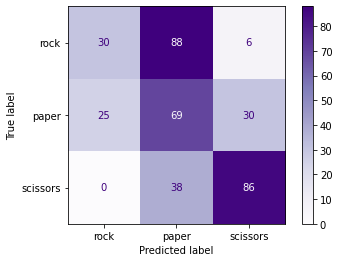

In [96]:
# generate accuracy metrics from the predictions using the model
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix, plot_confusion_matrix

# Print high level metrics of note
print('F1 Score: {:.2f}'.format(f1_score(test_labels, predicted_labels, average='weighted')))
print('Accuracy: {:.2f}'.format(accuracy_score(test_labels, predicted_labels)))
print('Recall: {:.2f}'.format(recall_score(test_labels, predicted_labels, average='weighted')))
print('Precision: {:.2f}'.format(precision_score(test_labels, predicted_labels, average='weighted')))
print()

# Display per-class metrics
print(classification_report(test_labels, predicted_labels))

# Display a confusion matrix with raw number counts
plot_confusion_matrix(model, test_data, test_labels, display_labels=['rock', 'paper', 'scissors'], cmap='Purples')

## Classifying Sample Images

### Helper Functions

In [32]:
def display_image(cv2Image):
    """
    Displays an OpenCV image in the Jupyter Notebook
    
    Args:
        cv2Image: The OpenCV image to display.
    """
    display(Image(data=cv2.imencode('.png', cv2Image)[1]))
    
def display_prediction(label, confidences):
    """
    Displays predictions and confidences for a predicted label and set of probabilities.
    
    Args:
        label: The predicted label.
        confidences: The predicted confidences for each label. This should be an array of 3 values.
    """
    print(f'Classifying as {label}')
    print(f'Paper Confidence: {confidences[0] * 100} %')
    print(f'Rock Confidence: {confidences[1] * 100} %')
    print(f'Scissors Confidence: {confidences[2] * 100} %')

def predict_image(image):
    # Flatten the image into a 1D array
    prediction_data = [image.flatten()]

    # Generate predictions and probabilities
    label = model.predict(prediction_data)
    confidence = model.predict_proba(prediction_data)

    return label[0], confidence[0]


def classify_image(image):
    # Process the image into a standardized form
    image = process_image(image)
    display_image(image)

    # Generate predictions and probabilities
    label, confidences = predict_image(image)
    display_prediction(label, confidences)
    return label

def classify_disk_image(filename):
    # Load and display the original image
    image = cv2.imread(filename)
    display_image(image)
    
    return classify_image(image)

### Test Cases

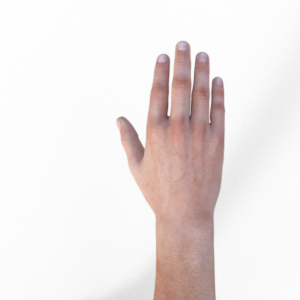

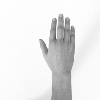

Classifying as scissors
Paper Confidence: 5.843332940528878e-24 %
Rock Confidence: 11.116217292492916 %
Scissors Confidence: 88.8837827075071 %


'scissors'

In [33]:
classify_disk_image('dataset/Rock-Paper-Scissors/test/paper/testpaper03-12.png')

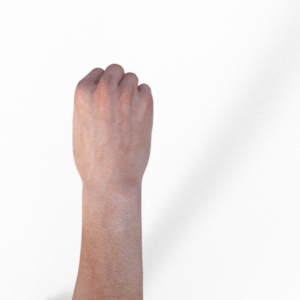

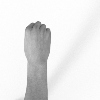

Classifying as rock
Paper Confidence: 9.604665950761534e-59 %
Rock Confidence: 99.99999970266636 %
Scissors Confidence: 2.9733364782502314e-07 %


'rock'

In [34]:
classify_disk_image('dataset/Rock-Paper-Scissors/test/rock/testrock03-12.png')

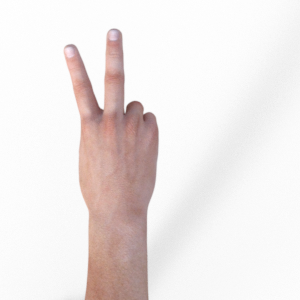

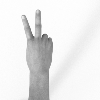

Classifying as rock
Paper Confidence: 4.699856484367064e-47 %
Rock Confidence: 99.99848901813453 %
Scissors Confidence: 0.001510981865467338 %


'rock'

In [35]:
classify_disk_image('dataset/Rock-Paper-Scissors/test/scissors/testscissors03-12.png')

## Grabbing an Image from the Primary Webcam

Successful read from camera 0 960.0x540.0
< cv2.VideoCapture 000001E4514DEAB0>


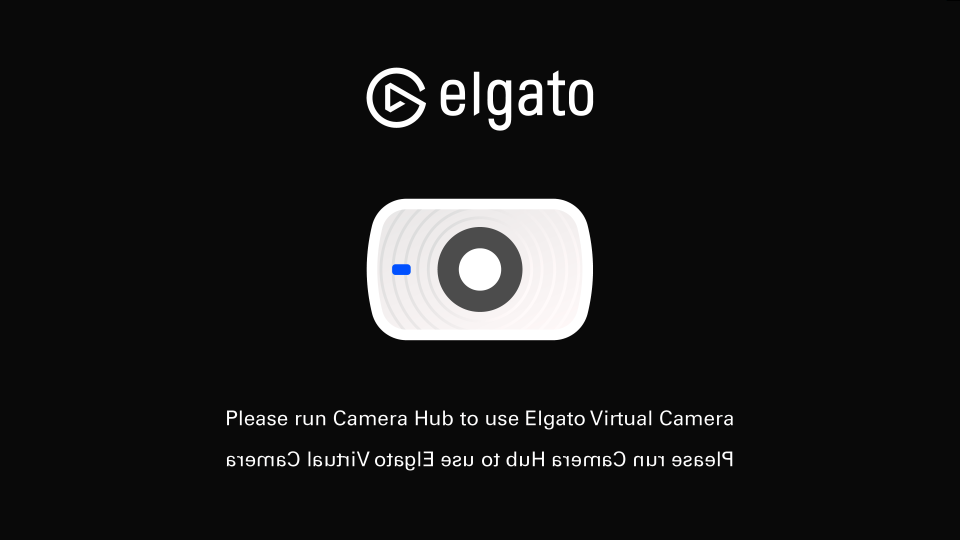

Successful read from camera 2 640.0x480.0
< cv2.VideoCapture 000001E4514DEAB0>


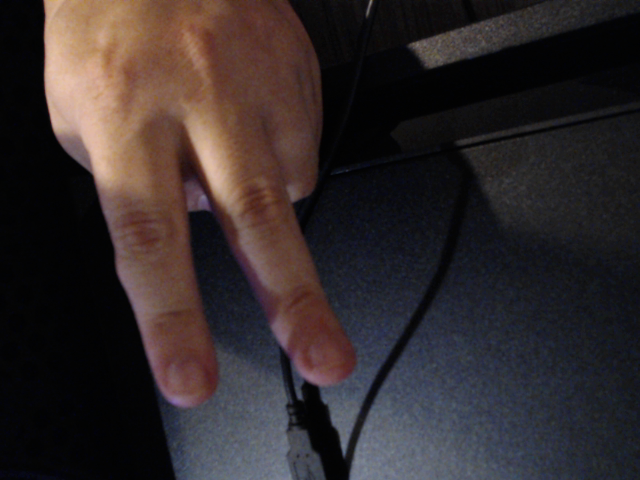

Using camera 2


In [36]:
video_index = -1

# Open CV doesn't tell us much about the video capture devices, so we need to try and see what works
for i in range(5):
    # Try to open the video device
    cap = cv2.VideoCapture(i)
    
    # Check if the video device was successfully opened
    if cap.isOpened():
        # Get the name of the video device for diagnoistics
        dimensions = f'{cap.get(cv2.CAP_PROP_FRAME_WIDTH)}x{cap.get(cv2.CAP_PROP_FRAME_HEIGHT)}'
        
        # Get a single image frame to test
        successful_read, frame = cap.read()

        # If we got an image, assume this is a good camera and update our index
        if successful_read:
            print('Successful read from camera', i, dimensions)
            print(cap)
            display_image(frame)
            video_index = i
        else:
            print('Failed to read from camera', i, dimensions)
        
    # Release the video device
    cap.release()

# Validate the camera
if video_index >= 0:
    print('Using camera', video_index)
else:
    print('No camera found. This notebook requires a webcam for full functionality')

In [37]:
def get_image_from_camera():
    cap = cv2.VideoCapture(video_index)

    # Get a single image frame
    _, frame = cap.read()

    # Release the camera
    cap.release()

    # Provide the image as the function result
    return frame

## Simulating Rock Paper Scissors

### Training a Classification Model on Past Games

### Predicting Player Moves

### Getting the Player's Image from Webcam

In [38]:
import time

def countdown(seconds):
    for i in range(seconds, 0, -1):
        print(i)
        time.sleep(1)

### Artificial Intelligence

In [39]:
import random

def predict_move():
    # TODO: Predict based on past choices
    return random.choice(['rock', 'paper', 'scissors'])

In [40]:
def get_opposing_move(predicted_move):
    if predicted_move == 'rock':
        return 'paper'
    elif predicted_move == 'paper':
        return 'scissors'
    else:
        return 'rock'

In [41]:
def determine_winner(player_move, ai_move):
    # First, check for a tie
    if player_move == ai_move:
        return 'tie'

    # Check to see if player won via rock
    if player_move == 'rock' and ai_move == 'scissors':
        return 'player'

    # Check to see if player won via scissors
    if player_move == 'scissors' and ai_move == 'paper':
        return 'player'

    # Check to see if player won via paper
    if player_move == 'paper' and ai_move == 'rock':
        return 'player'

    # The player failed to win and it wasn't a tie, therefore the AI won
    return 'ai'

### Storing Player Moves

### Move Confirmation & Correction Logic

In [50]:
def confirm_and_correct_move(move):
    print()
    print('It looks like you played', move)
    print('Is this correct? (Y/n)')
    answer = input()
    print()
    
    if answer.lower() == 'y':
        print('Fantastic!')
        return move
    
    print('Hmm. Alright, let\'s correct my read on this. Was this Rock (r), Paper (p), or Scissors (s)?')
    corrective_choice = input()[0]
    if corrective_choice.lower() == 'r':
        print('Okay, I\'ll treat that as rock')
        return 'rock'
    elif corrective_choice.lower() == 'p':
        print('Okay, I\'ll treat that as paper')
        return 'paper'
    elif corrective_choice.lower() == 's':
        print('Okay, I\'ll treat that as scissors')
        return 'scissors'
    else:
        print('I don\'t understand so I\'ll assume I was right and you chose', move)        
        return move

In [43]:
def display_game_result_message(winner):
    if winner == 'tie':
        print('Well, that was boring, but it was a tie. re-run the cell to play again.')
    elif winner == 'player':
        print('Human intelligence and randomness triumphs this time, but I stored your move and will learn from your patterns over time.')
    else:
        print('I win! The age of robot dominance has begun! Is it a fluke? Re-run the cell to play again and find out!')

### Move Prediction

In [60]:
import pandas as pd

history_file = 'game_history.csv'
min_moves_for_learning = 5

def load_game_history():
    if not os.path.exists(history_file):
        print('No historical data found. Creating file and starting from scratch.')
        df = pd.DataFrame(columns=['t_minus_1_player_move', 't_minus_1_winner', 't_minus_2_player_move', 't_minus_2_winner', 'next_move'])
        df.to_csv(history_file, index=False)
    else:
        df = pd.read_csv(history_file)
        print('Loaded historical move data containing', df.shape[0], 'moves.')
    
    if df.shape[0] < min_moves_for_learning:
        print('Not enough historical data found. The first', min_moves_for_learning - df.shape[0], 'moves will be random.')
    return df

## Game Loop

Time for some Rock, Paper, Scissors! I will count down to 0 and then take a picture of you. Hold up your hand in rock, paper, or scissors and I will try to guess what you are holding up.
While you do this, I will make a prediction about what I expect you will hold up and I will select the opposing move.
Every move you make will be stored to help train me to predict your actions better

Ready? Here we go!

Loaded historical move data containing 0 moves.
Not enough historical data found. The first 5 moves will be random.
3
2
1

Here is the image I captured of you


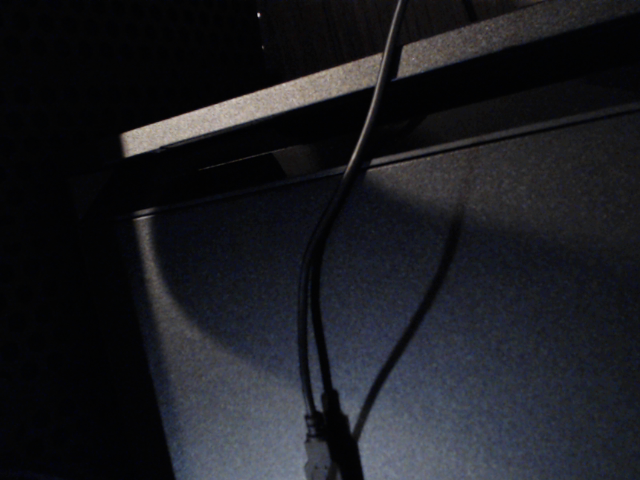

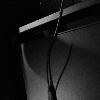

Classifying as paper
Paper Confidence: 99.9999999656233 %
Rock Confidence: 4.307716481539589e-13 %
Scissors Confidence: 3.437627316157339e-08 %

It looks like you played paper
Is this correct? (Y/n)

Fantastic!

I predicted you would play rock so I played paper

Well, that was boring, but it was a tie. re-run the cell to play again.


In [61]:
# Instructions
print('Time for some Rock, Paper, Scissors! I will count down to 0 and then take a picture of you. Hold up your hand in rock, paper, or scissors and I will try to guess what you are holding up.')
print('While you do this, I will make a prediction about what I expect you will hold up and I will select the opposing move.')
print('Every move you make will be stored to help train me to predict your actions better')
print()
print('Ready? Here we go!')
print()

# Load the CSV file
df_history = load_game_history()

# TODO: Train the model from this data

# Generate a prediction before the player makes their move
predicted_move = predict_move()

# Countdown and get the player's move image from their webcam
countdown(3)
player_img = get_image_from_camera()

# Analyze the image and classify it to a player move
print()
print('Here is the image I captured of you')
display_image(player_img)
move = classify_image(player_img)

# Confirm move with player. This is a safety net for poorly fit models or models that do not perform well against the actual camera environment
move = confirm_and_correct_move(move)

# TODO: Store the move and recent history in the CSV file for future training

# Display the predicted move
print()
ai_move = get_opposing_move(predicted_move)
print('I predicted you would play', predicted_move, 'so I played', ai_move)

# Display the game result
print()
winner = determine_winner(move, ai_move)
display_game_result_message(winner)

## Exploring Game Trends